Dataset shape: (400, 5)


,date,sales,ad_spend,platform,segment
0,2023-01-01,78321,7392.653530,Facebook,B2B
1,2023-01-02,72734,5554.291935,Google,B2C
2,2023-01-03,71285,2732.881456,Google,B2C
3,2023-01-04,100976,13241.390891,Facebook,B2C
4,2023-01-05,87582,12567.713119,Facebook,B2C


--- Linear Regression ---
MAE : 6,342.74
RMSE: 8,442.16
R²  : 0.6030
--- Random Forest ---
MAE : 7,572.54
RMSE: 9,927.18
R²  : 0.4510


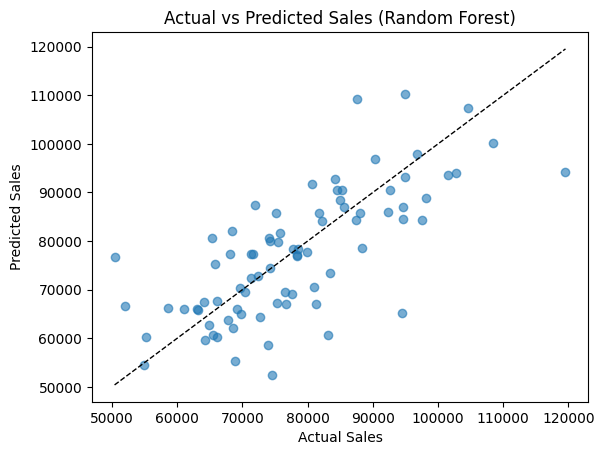


Top positive drivers (Linear Regression coefficients):


,feature,coef
0,ad_spend,10349.669721
2,platform_Google,5380.489115
5,segment_B2B,2297.245967
3,platform_Instagram,709.470368
6,segment_B2C,-2297.245967
4,platform_TikTok,-2800.192874
1,platform_Facebook,-3289.766609



Top negative drivers:


,feature,coef
0,ad_spend,10349.669721
2,platform_Google,5380.489115
5,segment_B2B,2297.245967
3,platform_Instagram,709.470368
6,segment_B2C,-2297.245967
4,platform_TikTok,-2800.192874
1,platform_Facebook,-3289.766609


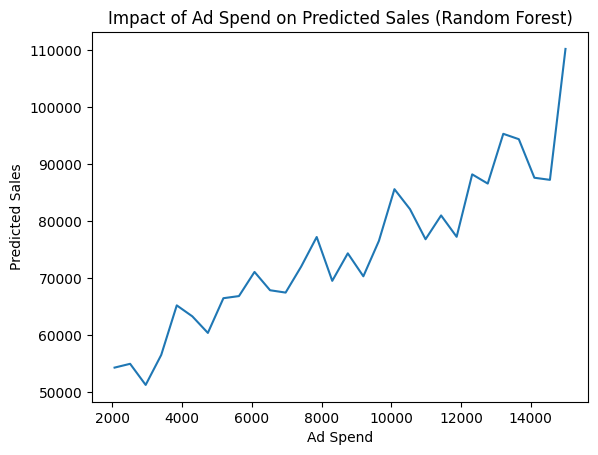

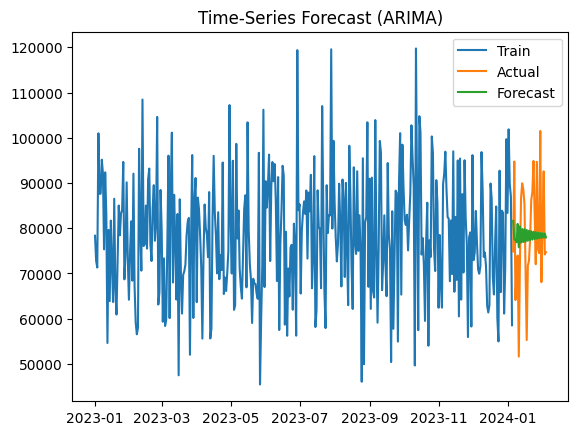


Time-Series Forecast Performance (ARIMA):
MAE : 9,639.98
RMSE: 11,518.01

=== ACTIONABLE INSIGHTS ===
• Among tested models, **Linear Regression** achieved the higher R² on the test set.
• Linear model suggests +1 unit of **ad_spend** changes sales by ~ **10349.67** units (holding other features constant).
• Categories most positively associated with sales: platform_Google, segment_B2B, platform_Instagram
• A/B test higher ad budgets on the best-performing platform/segment for 2–4 weeks; measure lift.
• Rebalance spend toward channels with stronger marginal impact; watch diminishing returns.
• Use time-series patterns (seasonality/trends) to plan campaign bursts and inventory.


In [4]:
# =========================================================
# TASK 4: Sales Prediction using Python – Colab Ready (Fixed)
# Compatible with older scikit-learn (no 'squared' arg), robust OHE names
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# ---------------------------------------------------------
# 1) LOAD DATA
# OPTION A: Direct CSV link
# url = "https://example.com/your_sales_dataset.csv"   # <-- REPLACE
# df = pd.read_csv(url)

# OPTION B: Upload from your computer
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv(next(iter(uploaded.keys())))

# --- Demo fallback so notebook runs even without your file ---
n = 400
df = pd.DataFrame({
    "date": pd.date_range("2023-01-01", periods=n, freq="D"),
    "sales": np.random.normal(50000, 6000, n).astype(int),
    "ad_spend": np.random.uniform(2000, 15000, n),
    "platform": np.random.choice(["Facebook","Google","Instagram","TikTok"], n, p=[0.35,0.35,0.2,0.1]),
    "segment": np.random.choice(["B2B","B2C"], n, p=[0.4,0.6]),
})
# Create signal so models learn something:
df["sales"] = (df["sales"]
               + 2.8*df["ad_spend"]
               + np.where(df["platform"]=="Google", 8000, 0)
               + np.where(df["platform"]=="Instagram", 3000, 0)
               + np.where(df["segment"]=="B2B", 4000, 0)
               + np.random.normal(0, 4000, n)).astype(int)

print("Dataset shape:", df.shape)
display(df.head())

# ---------------------------------------------------------
# 2) BASIC CLEANING
raw = df.copy()

# Find a date column if present
date_col = None
for c in df.columns:
    if "date" in c.lower():
        date_col = c
        break

target_col = "sales"
assert target_col in df.columns, f"Target column '{target_col}' not found."

# ---------------------------------------------------------
# 3) FEATURE/TARGET SPLIT for REGRESSION
feature_cols = [c for c in df.columns if c not in [target_col, date_col]]
X = df[feature_cols].copy()
y = df[target_col].copy()

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------
# 4) MODELS
linreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

linreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_lr = linreg.predict(X_test)
pred_rf = rf.predict(X_test)

# ---------------------------------------------------------
# 5) EVALUATION (fixed RMSE computation for older sklearn)
def evaluate(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # <-- fixed: no 'squared' arg
    r2 = r2_score(y_true, y_pred)
    print(f"--- {label} ---")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

m_lr = evaluate(y_test, pred_lr, "Linear Regression")
m_rf = evaluate(y_test, pred_rf, "Random Forest")

# Scatter: Actual vs Predicted (RF)
plt.figure()
plt.scatter(y_test, pred_rf, alpha=0.6)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (Random Forest)")
lims = [min(y_test.min(), pred_rf.min()), max(y_test.max(), pred_rf.max())]
plt.plot(lims, lims, "k--", linewidth=1)
plt.show()

# ---------------------------------------------------------
# 6) AD SPEND IMPACT: Linear Coefficients + PDP-like curve
# Safely extract OHE feature names across sklearn versions
def get_ohe_feature_names(ohe, input_features):
    names = None
    try:
        names = ohe.get_feature_names_out(input_features)
    except AttributeError:
        # Older sklearn
        try:
            names = ohe.get_feature_names(input_features)
        except Exception:
            names = np.array([])
    return names if isinstance(names, np.ndarray) else np.array(names)

cat_feature_names = np.array([])
if len(categorical_cols):
    ohe = linreg.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = get_ohe_feature_names(ohe, categorical_cols)

num_feature_names = np.array(numeric_cols)
feature_names = np.concatenate([num_feature_names, cat_feature_names])

coef = linreg.named_steps["model"].coef_
# Align length check (in case of empty cats)
if len(feature_names) != len(coef):
    # Fallback: just index numbers
    feature_names = np.array([f"f_{i}" for i in range(len(coef))])

coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)

print("\nTop positive drivers (Linear Regression coefficients):")
display(coef_df.head(10))
print("\nTop negative drivers:")
display(coef_df.tail(10))

# PDP-like curve for ad_spend if present
if "ad_spend" in X.columns:
    ad_min, ad_max = X["ad_spend"].min(), X["ad_spend"].max()
    grid = np.linspace(ad_min, ad_max, 30)

    # Build a baseline row: medians for numerics, mode for categoricals
    baseline = {}
    for c in X.columns:
        if c == "ad_spend":  # will be set per grid
            continue
        if c in numeric_cols:
            baseline[c] = float(X[c].median())
        else:
            baseline[c] = X[c].mode()[0]

    rows = []
    for v in grid:
        row = baseline.copy()
        row["ad_spend"] = float(v)
        rows.append(row)
    pdp_df = pd.DataFrame(rows)

    # Ensure same columns/order
    for c in X.columns:
        if c not in pdp_df.columns:
            pdp_df[c] = baseline.get(c, 0.0)
    pdp_df = pdp_df[X.columns]

    pred_curve = rf.predict(pdp_df)

    plt.figure()
    plt.plot(grid, pred_curve)
    plt.xlabel("Ad Spend")
    plt.ylabel("Predicted Sales")
    plt.title("Impact of Ad Spend on Predicted Sales (Random Forest)")
    plt.show()

# ---------------------------------------------------------
# 7) OPTIONAL: TIME-SERIES (ARIMA) if 'date' + 'sales' exist
if date_col is not None:
    try:
        from statsmodels.tsa.arima.model import ARIMA
        ts = raw[[date_col, target_col]].copy()
        ts[date_col] = pd.to_datetime(ts[date_col], errors="coerce")
        ts = ts.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
        ts = ts.asfreq("D").interpolate()

        train_ts = ts.iloc[:-30]
        test_ts = ts.iloc[-30:]

        model_ts = ARIMA(train_ts[target_col], order=(5,1,2))
        res_ts = model_ts.fit()
        forecast = res_ts.forecast(steps=30)

        plt.figure()
        plt.plot(train_ts.index, train_ts[target_col], label="Train")
        plt.plot(test_ts.index, test_ts[target_col], label="Actual")
        plt.plot(test_ts.index, forecast.values, label="Forecast")
        plt.title("Time-Series Forecast (ARIMA)")
        plt.legend()
        plt.show()

        mae_ts = mean_absolute_error(test_ts[target_col], forecast.values)
        rmse_ts = np.sqrt(mean_squared_error(test_ts[target_col], forecast.values))  # fixed
        print("\nTime-Series Forecast Performance (ARIMA):")
        print(f"MAE : {mae_ts:,.2f}")
        print(f"RMSE: {rmse_ts:,.2f}")
    except Exception as e:
        print("\n[Info] Time-series step skipped (statsmodels missing or version issue).")
        print("Detail:", e)

# ---------------------------------------------------------
# 8) ACTIONABLE INSIGHTS
insights = []
better = "Random Forest" if m_rf["R2"] > m_lr["R2"] else "Linear Regression"
insights.append(f"• Among tested models, **{better}** achieved the higher R² on the test set.")

if "ad_spend" in X.columns:
    ad_row = coef_df[coef_df["feature"] == "ad_spend"]
    if not ad_row.empty:
        c = ad_row["coef"].values[0]
        insights.append(f"• Linear model suggests +1 unit of **ad_spend** changes sales by ~ **{c:.2f}** units (holding other features constant).")

if len(categorical_cols):
    cat_mask = coef_df["feature"].apply(lambda z: any(cc in str(z) for cc in categorical_cols))
    top_cat = coef_df[cat_mask].head(3)["feature"].tolist()
    if top_cat:
        insights.append("• Categories most positively associated with sales: " + ", ".join(top_cat))

insights.extend([
    "• A/B test higher ad budgets on the best-performing platform/segment for 2–4 weeks; measure lift.",
    "• Rebalance spend toward channels with stronger marginal impact; watch diminishing returns.",
    "• Use time-series patterns (seasonality/trends) to plan campaign bursts and inventory."
])

print("\n=== ACTIONABLE INSIGHTS ===")
for line in insights:
    print(line)
